# Vehicle Detection and Tracking

In this project, my goal is to write a software pipeline to identify vehicles in a video. This notebook itself would be the writeup too.

In [32]:
# Import basic libaray for processing

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label

%matplotlib inline


# The goals / steps of this project are the following:

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
2. Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
3. Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
4. Estimate a bounding box for vehicles detected.

# SVM Classifier Training
I pick all the taught features(HOG, Color Historgram, and Bin Spatial) in the Suport Vector machine Classifier training. For the paramters, I first follow with the lecture ones. Then modified them one by one to see the feature different between the car and non-car.
## Histogram of Oriented Gradients (HOG) feature

In [4]:
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler

In [5]:
carList = [
    'training_data/vehicles/GTI_Far/image0000.png',
    'training_data/vehicles/GTI_Left/image0009.png',
    'training_data/vehicles/GTI_MiddleClose/image0000.png',
    'training_data/vehicles/GTI_Right/image0000.png',
    'training_data/vehicles/KITTI_extracted/1.png'
]

non_carList = [
    'training_data/non-vehicles/GTI/image1.png',
    'training_data/non-vehicles/GTI/image101.png',
    'training_data/non-vehicles/GTI/image201.png',
    'training_data/non-vehicles/GTI/image301.png',
    'training_data/non-vehicles/Extras/extra1.png',
    'training_data/non-vehicles/Extras/extra101.png',
    'training_data/non-vehicles/Extras/extra201.png',
    'training_data/non-vehicles/Extras/extra301.png',
    'training_data/non-vehicles/Extras/extra401.png'
]


In [93]:
pix_per_cell = 8
cell_per_block = 2
orient = 9

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec, block_norm="L2-Hys")
        fig = plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(image, cmap='gray')
        plt.title('Training Data (Car Image)')
        plt.subplot(1,2,2)
        plt.imshow(hog_image, cmap='gray')
        plt.title('HOG Feature')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


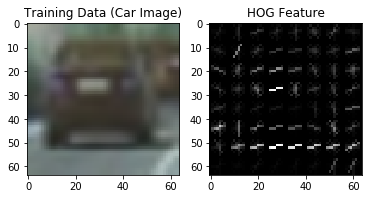

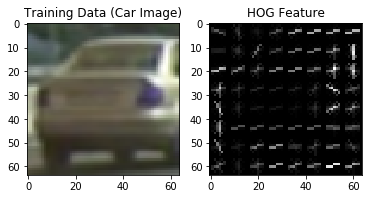

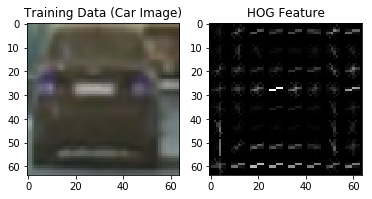

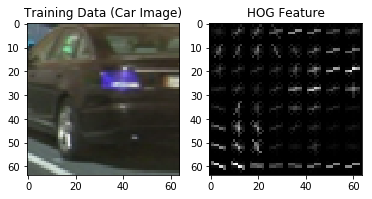

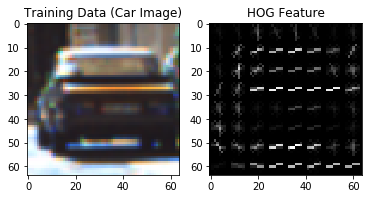

In [7]:
# Display Car data
for fileName in carList:
    image = cv2.imread(fileName)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

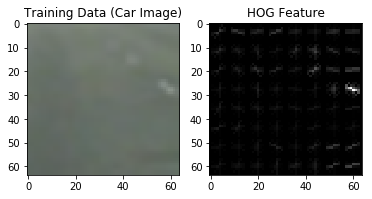

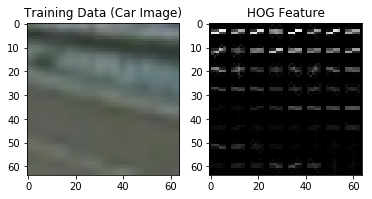

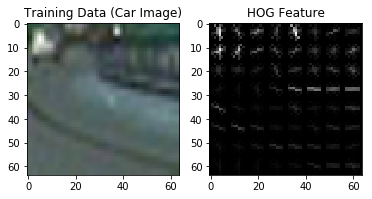

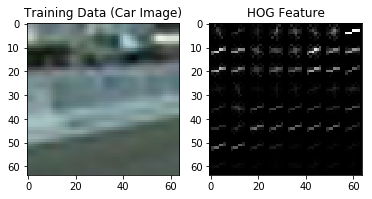

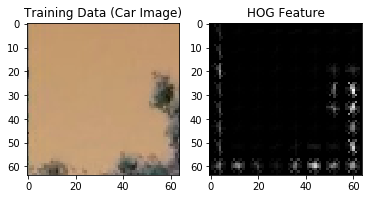

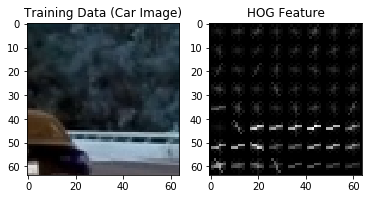

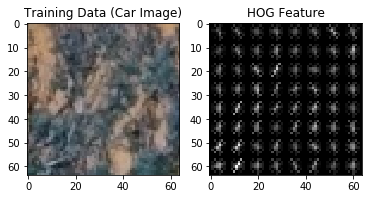

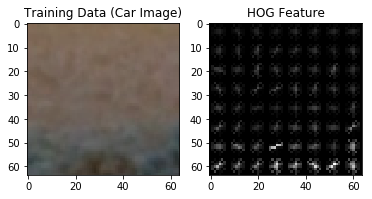

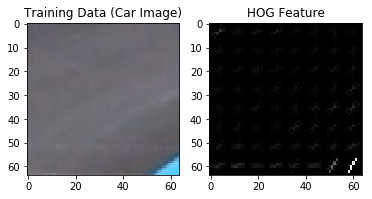

In [8]:
# Display Car data
for fileName in non_carList:
    image = cv2.imread(fileName)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

## Color Historgram

In [9]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256), isPrint=False):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Print Logic
    if isPrint:
        fig = plt.figure(figsize=(12,3))
        plt.subplot(1,4,1)
        plt.imshow(img)
        plt.subplot(1,4,2)
        plt.bar(bin_centers, rhist[0])
        plt.xlim(0, 256)
        plt.title('R Histogram')
        plt.subplot(1,4,3)
        plt.bar(bin_centers, ghist[0])
        plt.xlim(0, 256)
        plt.title('G Histogram')
        plt.subplot(1,4,4)
        plt.bar(bin_centers, bhist[0])
        plt.xlim(0, 256)
        plt.title('B Histogram')
        fig.tight_layout()
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

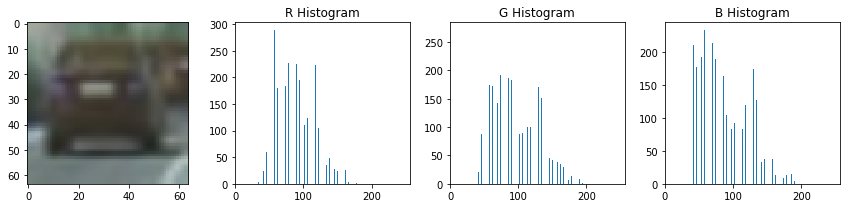

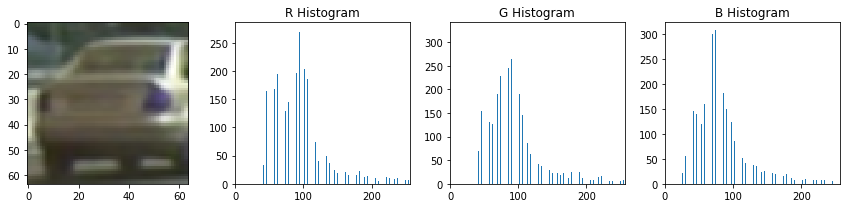

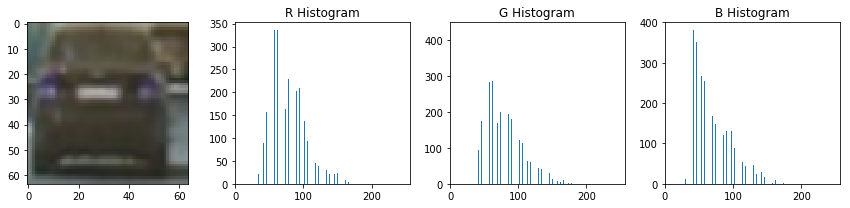

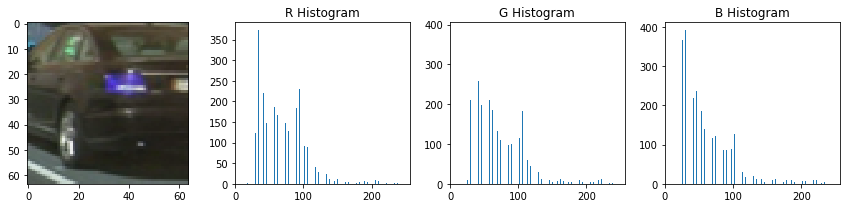

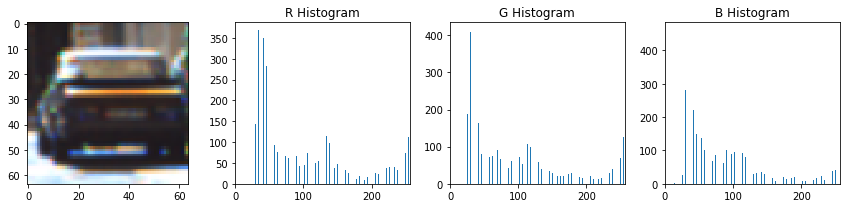

In [39]:
# Display Car data
for fileName in carList:
    image = cv2.imread(fileName)
    nbins=64 # 8, 16, 32, 64
    color_hist(image, nbins=nbins, isPrint=True)

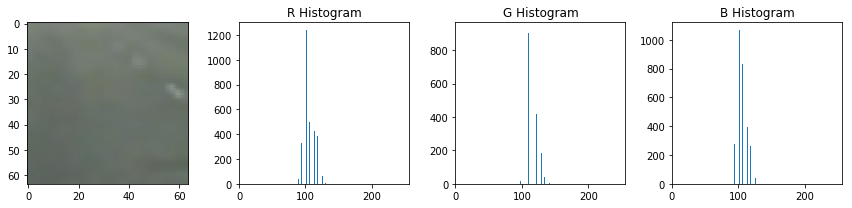

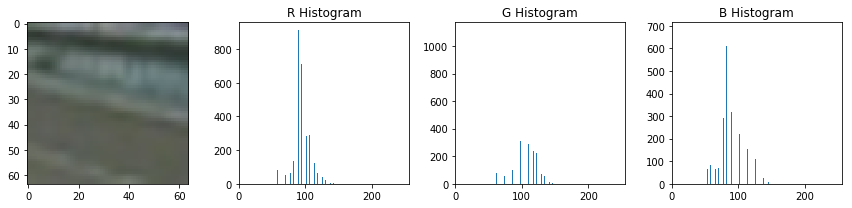

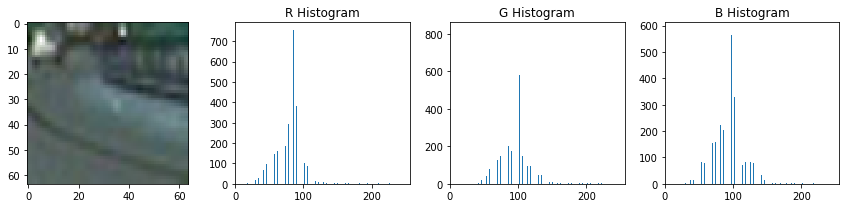

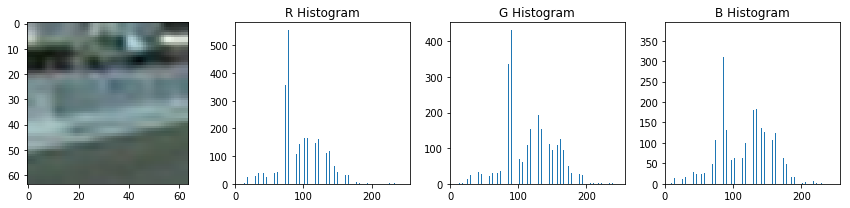

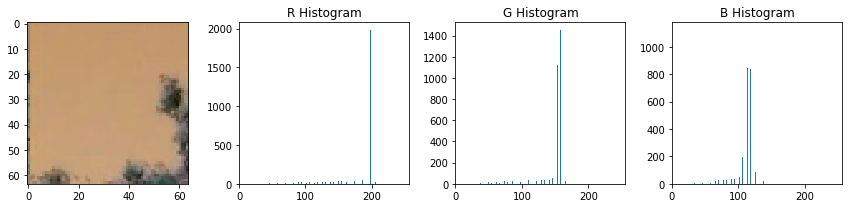

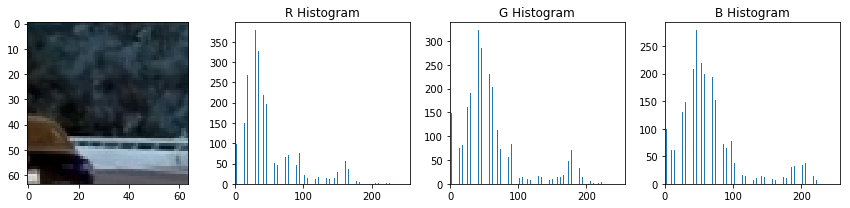

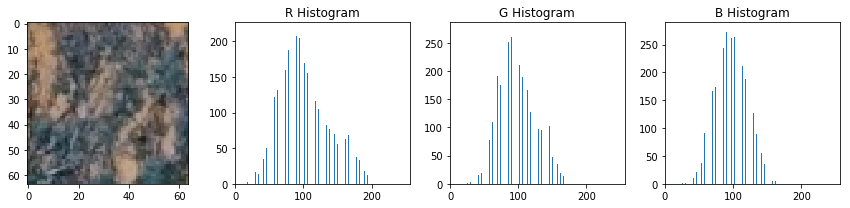

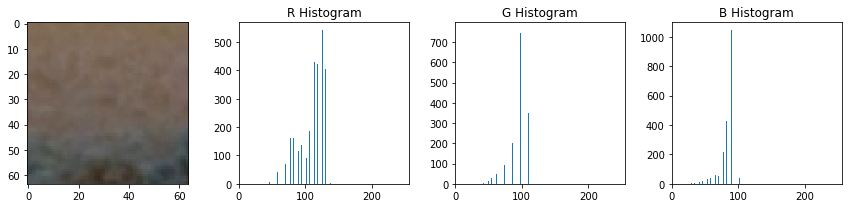

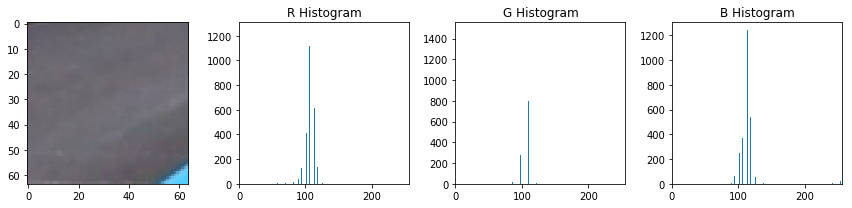

In [40]:
# Display Non Car data
for fileName in non_carList:
    image = cv2.imread(fileName)
    nbins=64 # 8, 16, 32, 64
    color_hist(image, nbins=nbins, isPrint=True)

## Bin Spatial

In [12]:
def bin_spatial(img, color_space='RGB', size=(32, 32), isPrint=False):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    if isPrint:
        fig = plt.figure(figsize=(12,3))
        plt.subplot(1,2,1)
        plt.imshow(img)
        plt.title('Image')
        plt.subplot(1,2,2)
        plt.plot(features)
        plt.title('Spatially Binned Features')
    # Return the feature vector
    return features

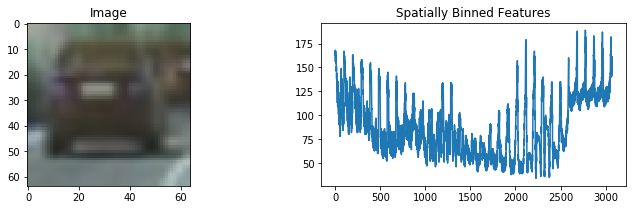

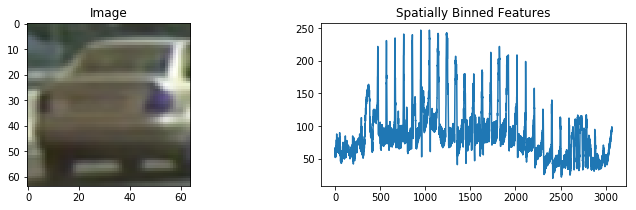

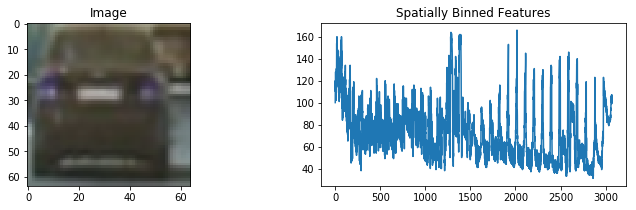

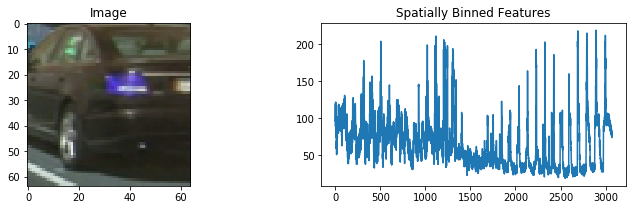

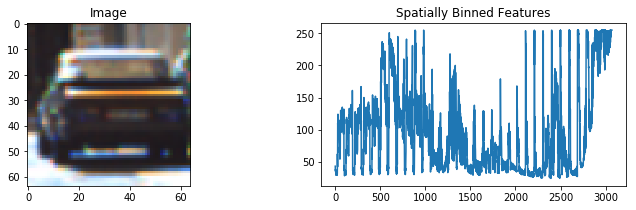

In [41]:
# Display Car data
for fileName in carList:
    image = cv2.imread(fileName)
    bin_size=(16, 16) # (16,16) (32, 32) (64,64)
    bin_spatial(image, isPrint=True)

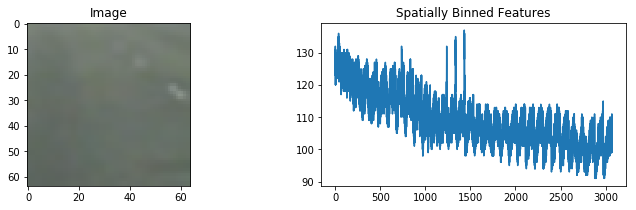

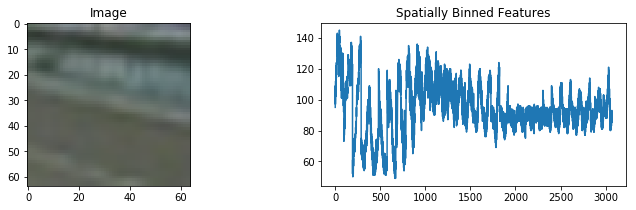

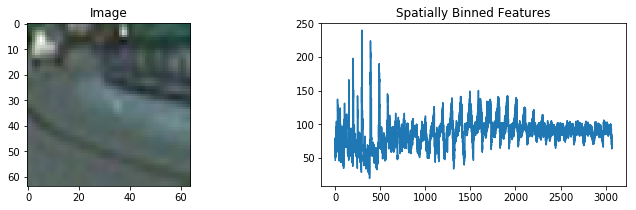

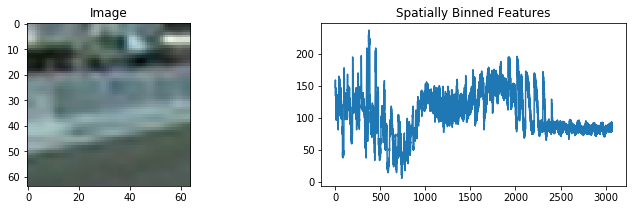

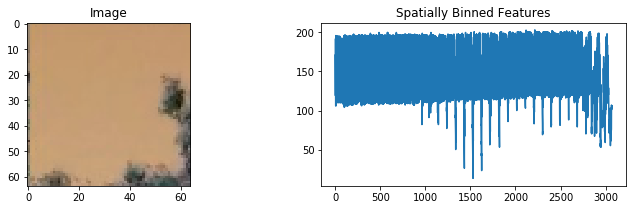

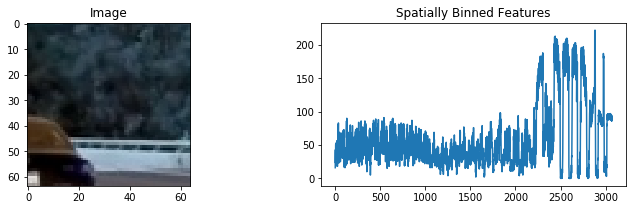

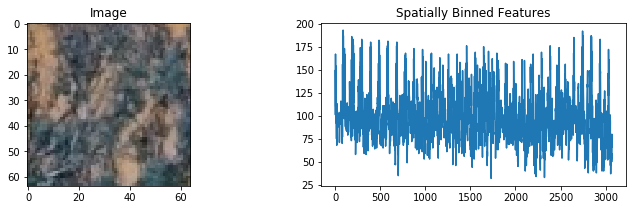

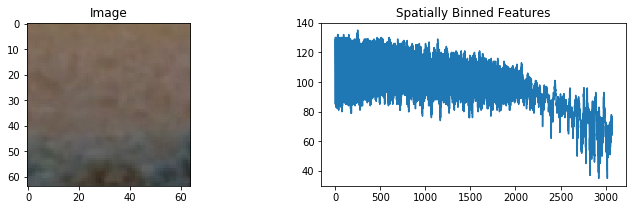

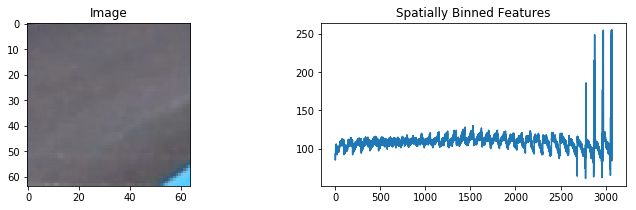

In [42]:
# Display Non Car data
for fileName in non_carList:
    image = cv2.imread(fileName)
    bin_size=(16, 16) # (16,16) (32, 32) (64,64)
    bin_spatial(image, isPrint=True)

## Getting Features
### After prepared all feature extraction logic, we need to consolidate them with a single image input. 
### Extract_feature: Extract features from a single image
### Extract_features: Extract features from image(s)

In [36]:
def extract_feature(img, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):    
    img_features = []
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
        
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    img_features.append(spatial_features)
    
    hist_features = color_hist(feature_image, nbins=hist_bins)
    img_features.append(hist_features)
    
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))      
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    img_features.append(hog_features)

#     print('spatial_features:%d, hist_features:%d, hog_features:%d'%(len(spatial_features), len(hist_features),len(hog_features)))
    return np.concatenate(img_features)

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        features.append(extract_feature(image, color_space, spatial_size,
                        hist_bins, orient, pix_per_cell, cell_per_block, hog_channel))
        features.append(extract_feature(cv2.flip(image,1), color_space, spatial_size,
                        hist_bins, orient, pix_per_cell, cell_per_block, hog_channel))
    return features

## Extracting features from training Data
Below paramteres were under fine tunning by trial. If possible, it is good to run some Grid Search library to locate the best feature hyperparameters.

In [107]:
ORIENT = 11  # HOG orientations              # 9, 11
PIX_PER_CELL = 8 # HOG pixels per cell       # 16, 32
CELL_PER_BLOCK = 2 # HOG cells per block     # 4, 8, 16, 32

SPATIAL_SIZE = (16, 16) # Spatial binning dimensions

HIST_BINS = 16    # Number of histogram bins

COLOR_SPACE = 'YCrCb'                         # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

HOG_CHANNEL = 'ALL'                           # 0, 1, 2, ALL

cars_files = glob.glob('training_data/vehicles/**/*.png', recursive=True)
non_cars_files = glob.glob('training_data/non-vehicles/**/*.png', recursive=True)

car_features = extract_features(cars_files, color_space=COLOR_SPACE, spatial_size=SPATIAL_SIZE,
                        hist_bins=HIST_BINS, orient=ORIENT, 
                        pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, hog_channel=HOG_CHANNEL)

non_car_features = extract_features(non_cars_files, color_space=COLOR_SPACE, spatial_size=SPATIAL_SIZE,
                        hist_bins=HIST_BINS, orient=ORIENT, 
                        pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, hog_channel=HOG_CHANNEL)

C:\Software\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [108]:
print('Car Data Size and number of Features',np.array(car_features).shape)
print('Non-Car Data Size and number of Features',np.array(non_car_features).shape)

Car Data Size and number of Features (17584, 7284)
Non-Car Data Size and number of Features (17936, 7284)


## Normalize the training data

In [109]:
# Vertically stack all features
X = np.vstack((car_features, non_car_features)).astype(np.float64)                        
# Compute the scaler and normlize the data by library
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Stack the label
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

## Data Pick Checking
Below Data pick can allow us to see the importance of the data normalization. One of the feautre obviously dominant the trend if we do not apply normalization.

In [110]:
def data_pick():
    car_ind = np.random.randint(0, len(cars_files))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1, 3, 1)
    plt.imshow(mpimg.imread(cars_files[car_ind]))
    plt.title('Original Image')
    plt.subplot(1, 3, 2)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(1, 3, 3)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()

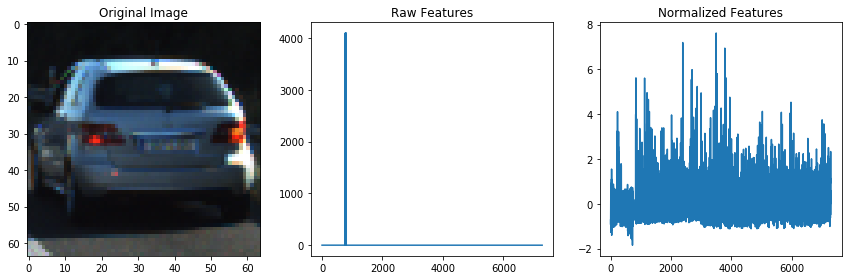

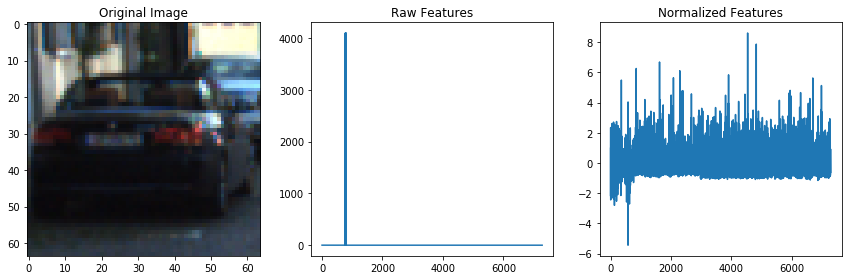

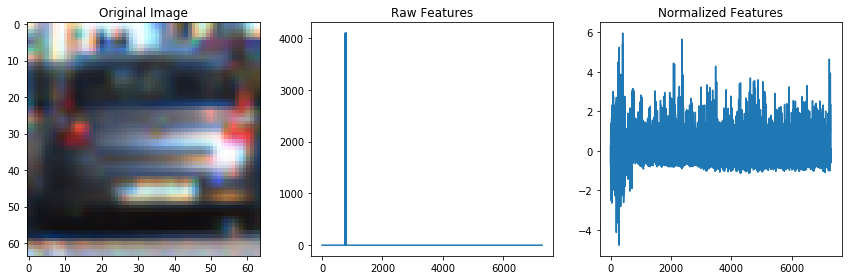

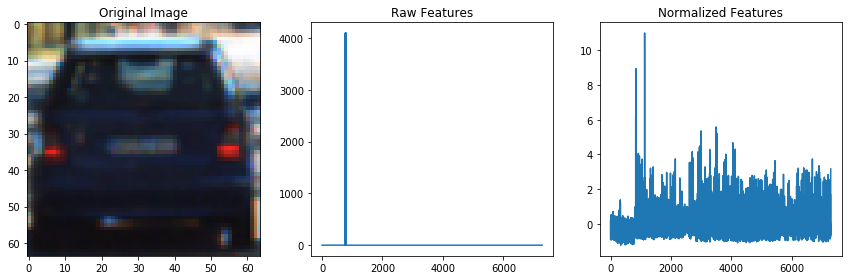

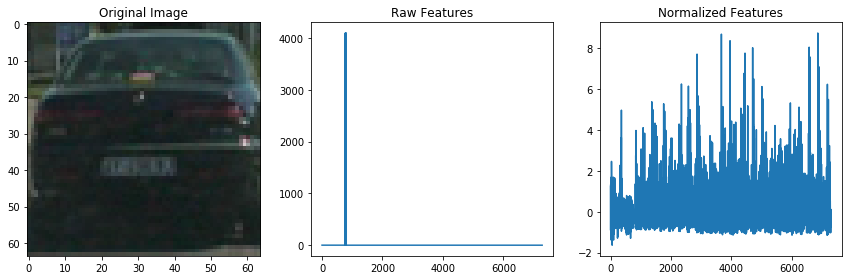

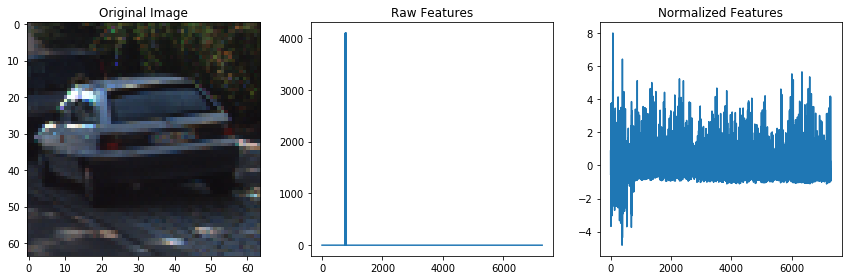

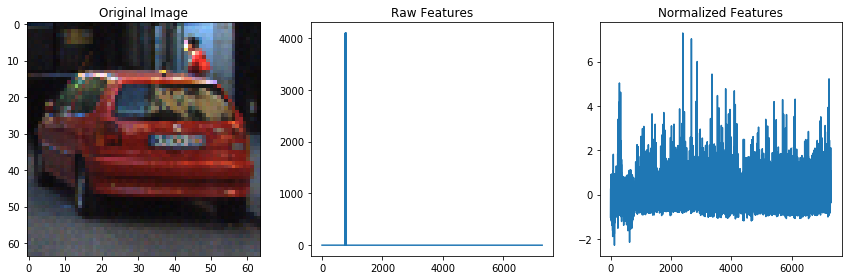

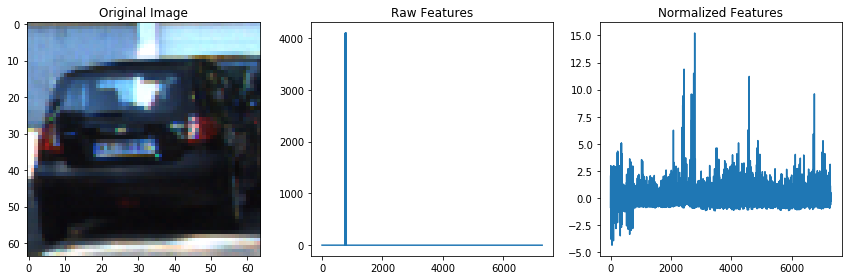

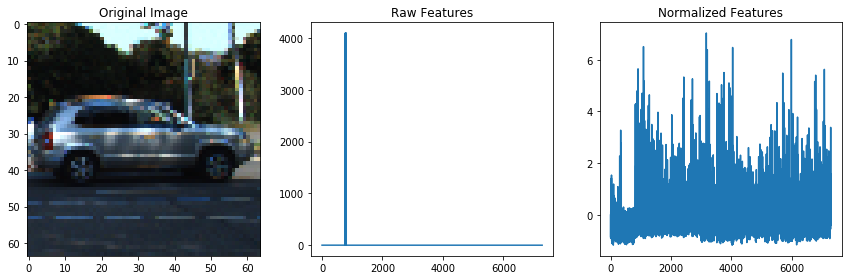

In [111]:
for i in range(1,10):
    data_pick()

## Apply Linear SVC
We split 20% of data for validation with Shuffling.

In [112]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, shuffle = True)

# Use a linear SVC 
svc = LinearSVC()
svc.fit(X_train, y_train)

print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.989


# Sliding Window Search
## Function Define (Quote from Lecture)


In [113]:
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


## Window Place and size analysis
A High Level look and feel to see where the window should be placed to meet the car. The cars should be covered by 400 y-max with small size and probably up to 500 y-max with relatively larger size(closer).

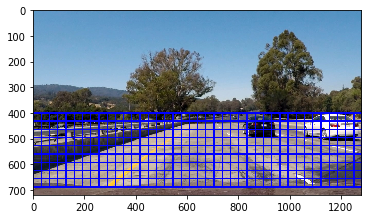

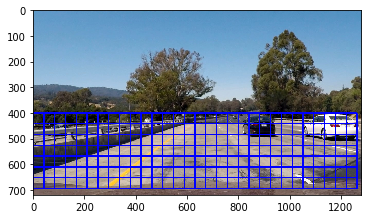

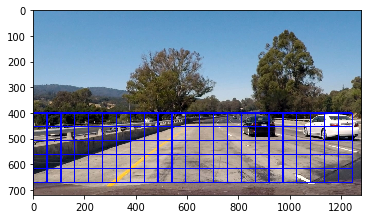

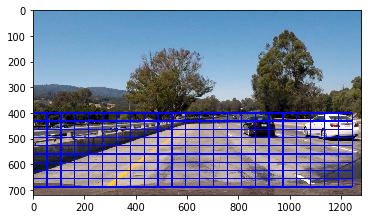

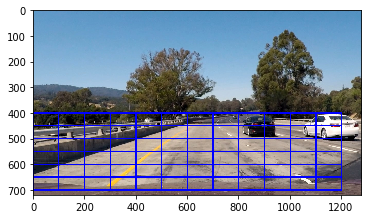

In [123]:
y_start_stop = [400, 700]

test_img = mpimg.imread('test_images/test1.jpg')

xy_windows = [(64,64), (84,84), (108, 108), (108, 64), (200, 100)]
for idx, xy_window in enumerate(xy_windows):
    bboxes = slide_window(test_img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=(0.5, 0.5))
    test_result1 = draw_boxes(test_img, bboxes, thick=3)
    plt.figure(figsize=(20,12))
    plt.subplot(len(xy_windows)//3 + 1, 3,idx+1)
    plt.imshow(test_result1)


## Search Window
From above result, I choose several levels of window size with different upper y-max limit and also the x-asix occurence times.

In [124]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using extract_feature()
        features = extract_feature(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def stride_windows(img, win_size, num_win_x, y_top):
    x_right = img.shape[1] - win_size
    x_stride = int(round(x_right / (num_win_x-1)))
    windows = []
    for xs in range(num_win_x-1):
        windows.append(((xs*x_stride, y_top), (xs*x_stride+win_size, y_top+win_size)))
    # Make sure that the last window is pushed all the way to the edge
    windows.append(((x_right, y_top),(img.shape[1], y_top+win_size)))
    return windows



### form_windows function is to provide a suitable guidance on how we draw rectangle on the plane. The rationale is as mentioned before, i.e. the closer, the larger.

In [125]:
def form_windows(image):
    windows = []
    coords = [
        (75, 50, 400),
        (100, 40, 400),
        (125, 35, 400),
        (175, 30, 450),
        (225, 20, 500)
    ]
    for win_size, num_win_x, y_top in coords:
        windows.extend(stride_windows(image, win_size, num_win_x, y_top))
    return windows

C:\Software\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


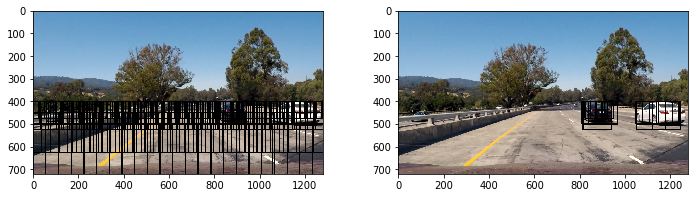

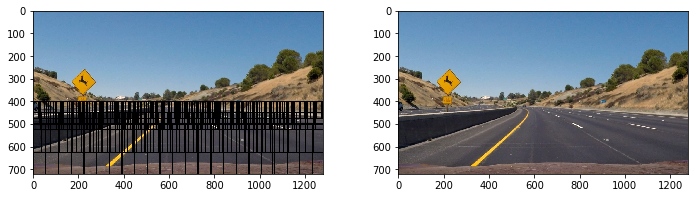

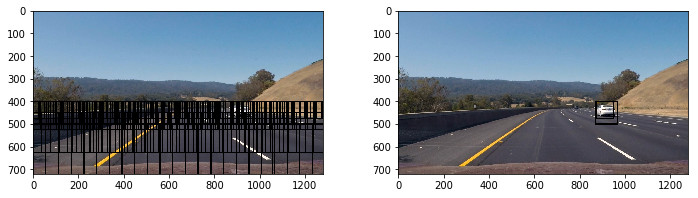

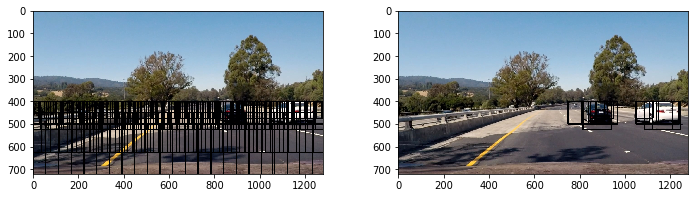

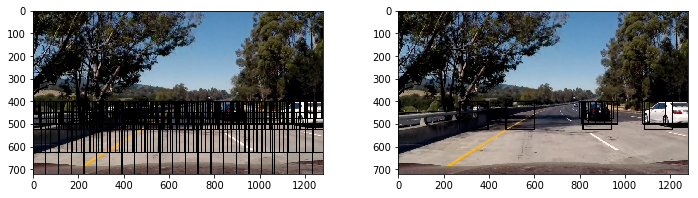

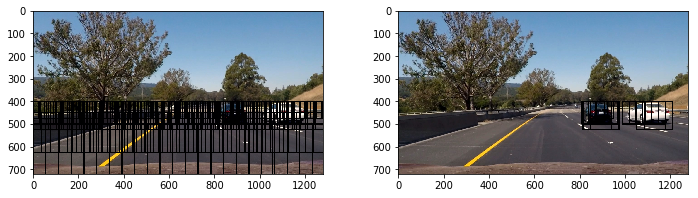

In [126]:
test_files = glob.glob('test_images/*.jpg')
for test_file in test_files:
    test_img = mpimg.imread(test_file)
    test_img = test_img.astype(np.float32)/255
    windows = form_windows(test_img)

    test_result1 = draw_boxes(test_img, windows, thick=3)

    fig = plt.figure(figsize=(12,3))
    plt.subplot(1,2,1)
    plt.imshow(test_result1)

    windows2 = search_windows(test_img, windows, svc, X_scaler, color_space=COLOR_SPACE, 
                                spatial_size=SPATIAL_SIZE, hist_bins=HIST_BINS, 
                                orient=ORIENT, pix_per_cell=PIX_PER_CELL, 
                                cell_per_block=CELL_PER_BLOCK, 
                                hog_channel="ALL")

    test_result2 = draw_boxes(test_img, windows2, thick=3)
    plt.subplot(1,2,2)
    plt.imshow(test_result2)

# Handling of Multiple detection
Following the lecture, I use the heat map method to deduce the multiple selection. If my classifier is strong enough, I can choose to select more window for detection while the muliple detection part could be handled here

In [27]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [133]:
def pipeline(image, return_heatmap=False, heatmap_threshold=2):
    image = image.astype(np.float32)/255

    windows = form_windows(image)

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=COLOR_SPACE, 
                            spatial_size=SPATIAL_SIZE, hist_bins=HIST_BINS, 
                            orient=ORIENT, pix_per_cell=PIX_PER_CELL, 
                            cell_per_block=CELL_PER_BLOCK, 
                            hog_channel='ALL')                       

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,heatmap_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image)*255, labels)
    if return_heatmap:
        return draw_img, heatmap
    return draw_img


# Test Images result
## Test Images result (With heatmap thresholds = 1)

C:\Software\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


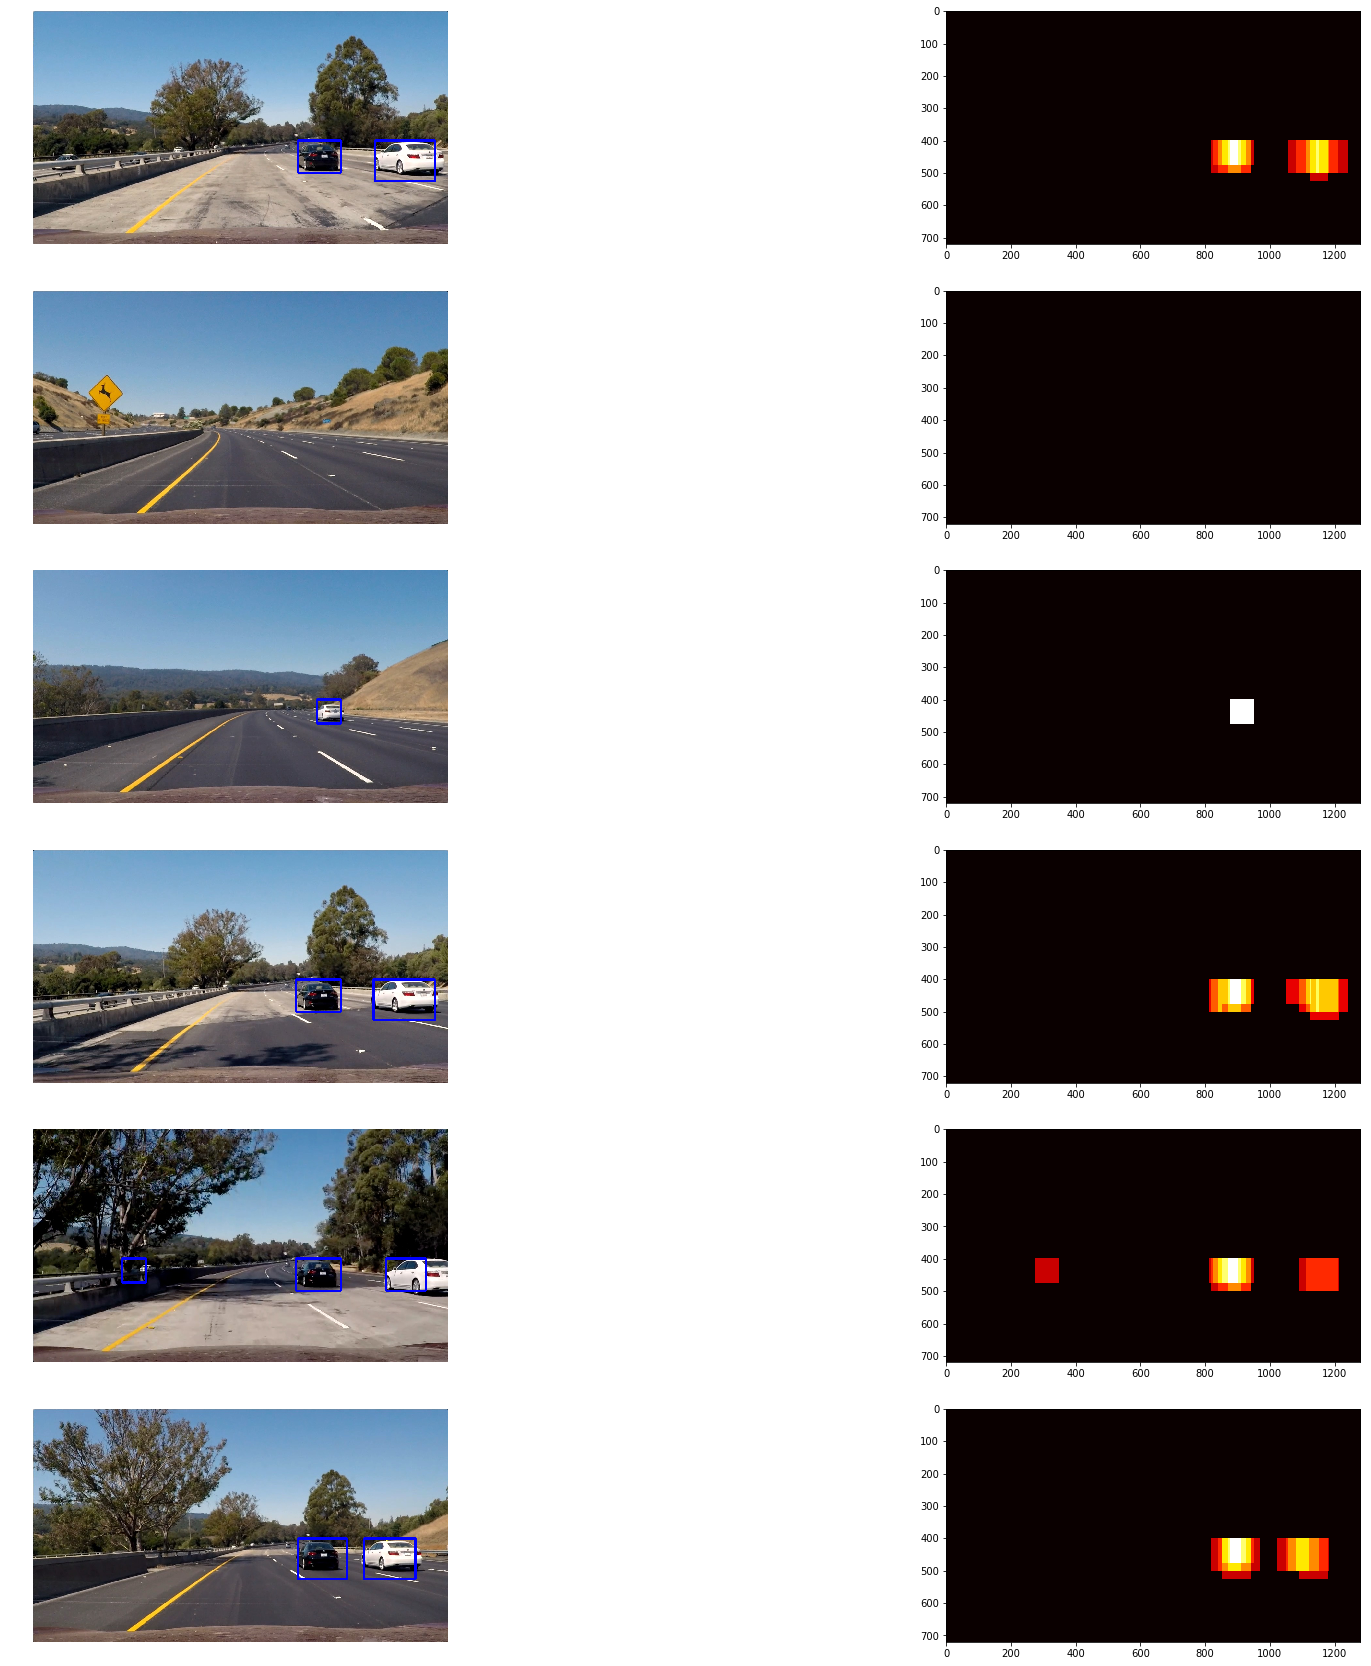

In [131]:
images = glob.glob('test_images/test*.jpg')
fig, axs = plt.subplots(len(images), 2, figsize=(30,30))
cnt = 0
for cnt, ax in enumerate(axs):
    img = mpimg.imread(images[cnt])
    draw_img, heatmap = pipeline(img, True, heatmap_threshold= 1)
    # Convert to uint8 so that imshow displays properly
    ax[0].imshow(draw_img.astype(np.uint8))
    ax[0].axis('off')
    ax[1].imshow(heatmap, cmap='hot')
plt.show()

## Test Image result (With heatmap thresholds = 2)

C:\Software\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


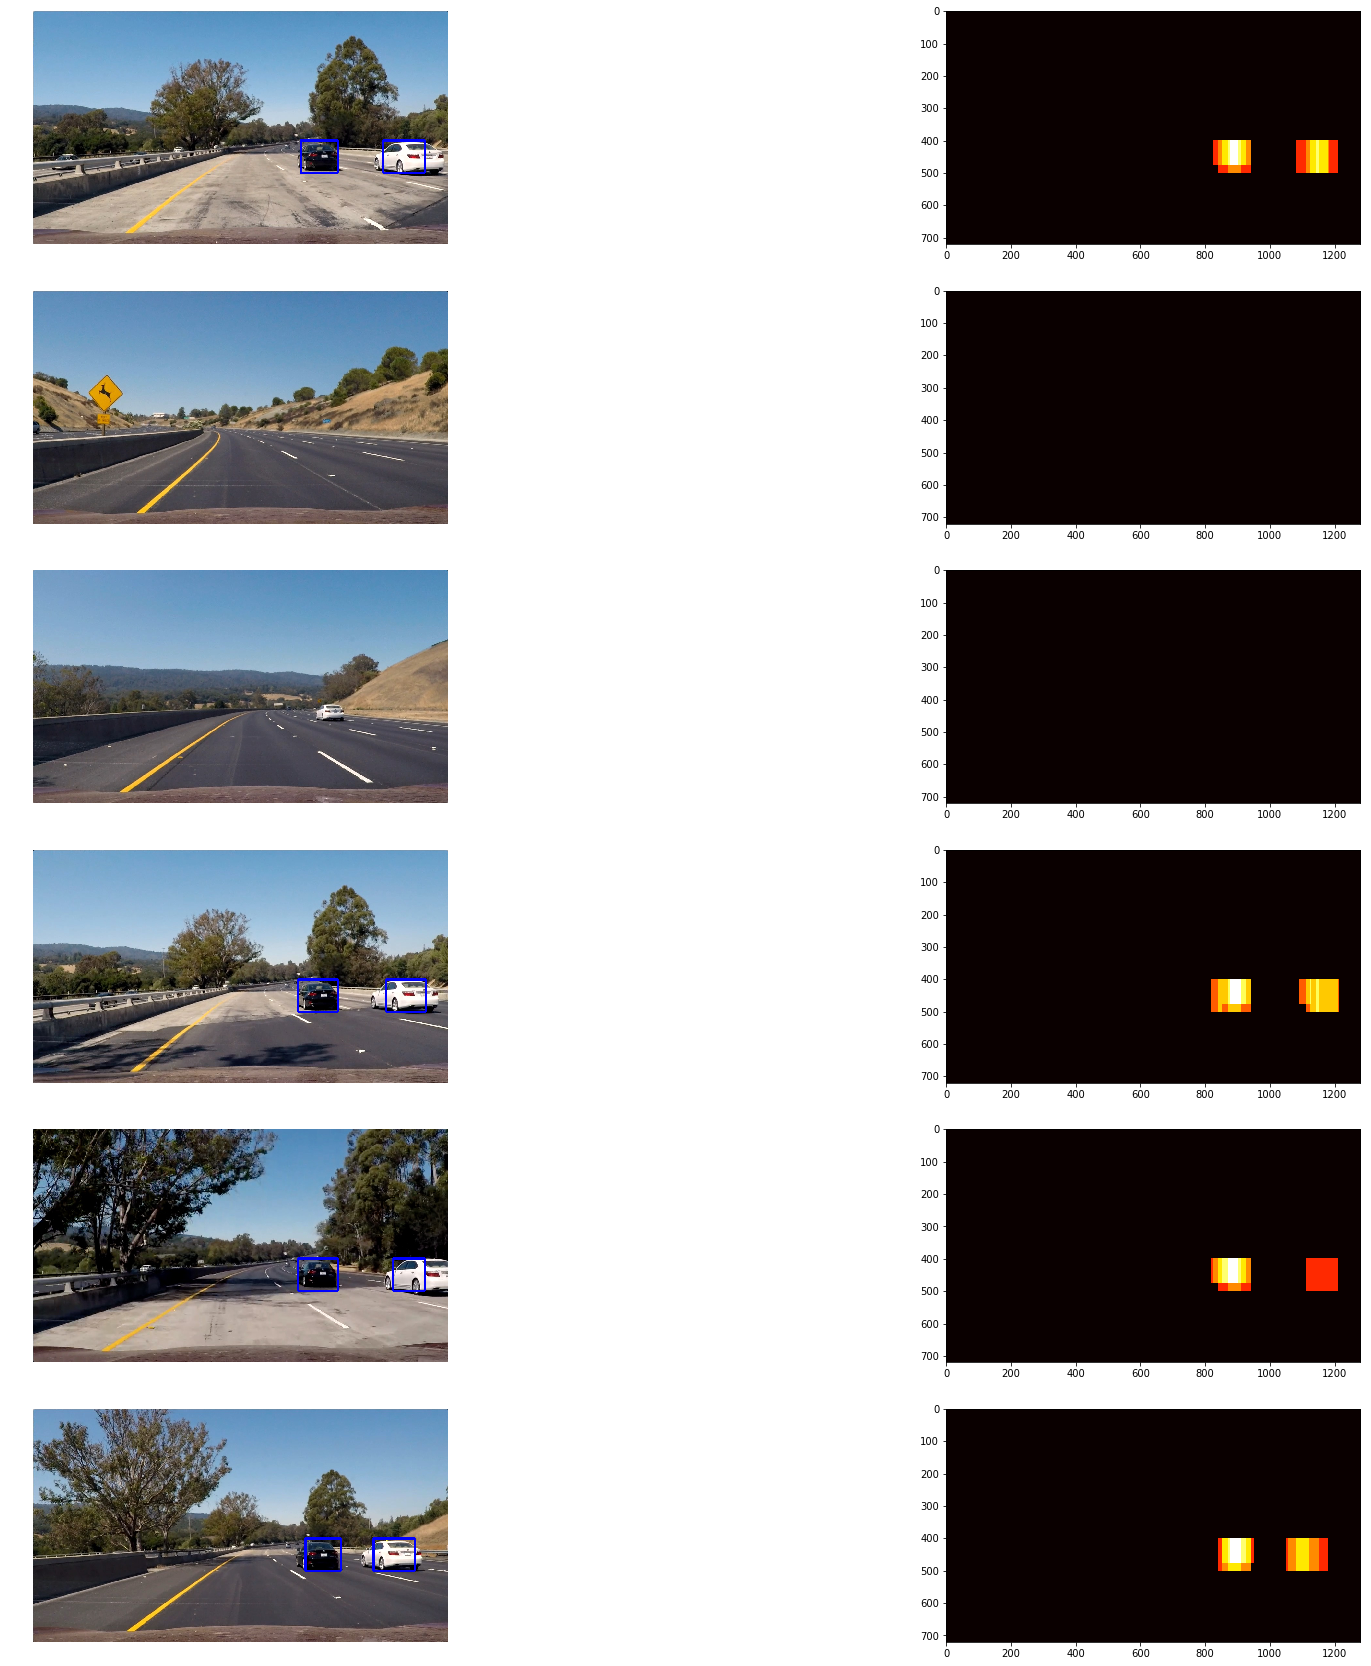

In [132]:
images = glob.glob('test_images/test*.jpg')
fig, axs = plt.subplots(len(images), 2, figsize=(30,30))
cnt = 0
for cnt, ax in enumerate(axs):
    img = mpimg.imread(images[cnt])
    draw_img, heatmap = pipeline(img, True, heatmap_threshold= 2)
    # Convert to uint8 so that imshow displays properly
    ax[0].imshow(draw_img.astype(np.uint8))
    ax[0].axis('off')
    ax[1].imshow(heatmap, cmap='hot')
plt.show()

### One can find that the heat map ratio could help to remove false positive, but would be also possible to remove some useful detection, especially for the far cases. But from my perspective, removing false posisitve is essential on increasing the accuracy for far objects detections. So i would choose to use thresold as 2,ie. it is treated as detected if there is at least two detected window.

# Video Implementation
## Test Video

In [134]:
def process_image(img):
    draw_img, heatmap = pipeline(img, True, heatmap_threshold= 1)
    return draw_img

from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Test Video pipeline
test_vid_res = 'test_video_result.mp4'
test_video = VideoFileClip('test_video.mp4')
result = test_video.fl_image(process_image)
result.write_videofile(test_vid_res, audio=False)

[MoviePy] >>>> Building video test_video_result.mp4
[MoviePy] Writing video test_video_result.mp4


 97%|██████████████████████████████████████████████████████████████████████████  | 38/39 [00:39<00:01,  1.02s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_result.mp4 



In [136]:

# Project Video pipeline
project_video_result = 'project_video_result.mp4'
project_video = VideoFileClip('project_video.mp4')
result = project_video.fl_image(process_image)
result.write_videofile(project_video_result, audio=False)


[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|███████████████████████████████████████████████████████████████████████▉| 1260/1261 [22:26<00:01,  1.04s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 



[Test Video Link](https://github.com/karabC/CarND-Vehicle-Detection/blob/master/test_video_result.mp4)

[Project Video Link](https://github.com/karabC/CarND-Vehicle-Detection/blob/master/project_video_result.mp4)

# Discussion
## Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?



During the implementation, the hardest part is the choice of the windows. Too fine grained windows would cause inaccurate classification while my pipeline would be mostly fail when the cars are too far due to choice of the window size. Some further tuning could be done on increasing the number of window and extension some small windows to far points. As mentioend, this would require increase of the heatmap threshold too to prevent false positive.